In [125]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
import cvxpy as cp
from scipy.stats import poisson, uniform, expon, pareto
from scipy.optimize import minimize, fsolve
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex
import requests
import json
import time
import gzip
import io
from datetime import datetime
import csv

In [134]:
df = pd.read_csv('height_time_fees_blockrew.csv', names=['height', 'time', 'fee', 'reward'], 
                 parse_dates=[1],)
df.head()

,height,time,fee,reward
0,500000,2017-12-18 18:35:25,339351625,1250000000
1,500001,2017-12-18 18:38:05,363420702,1250000000
2,500002,2017-12-18 18:41:04,341013739,1250000000
3,500003,2017-12-18 18:46:28,363546598,1250000000
4,500004,2017-12-18 18:47:21,289758471,1250000000


In [135]:
df.time[0], df.time[1], df.time[1]-df.time[0]

(Timestamp('2017-12-18 18:35:25'),
 Timestamp('2017-12-18 18:38:05'),
 Timedelta('0 days 00:02:40'))

In [136]:
df['time_diff'] = df['time'].diff(periods=1).abs().dt.total_seconds()
df = df.iloc[1:]
df.head()

,height,time,fee,reward,time_diff
1,500001,2017-12-18 18:38:05,363420702,1250000000,160.0
2,500002,2017-12-18 18:41:04,341013739,1250000000,179.0
3,500003,2017-12-18 18:46:28,363546598,1250000000,324.0
4,500004,2017-12-18 18:47:21,289758471,1250000000,53.0
5,500005,2017-12-18 19:05:31,443780733,1250000000,1090.0


In [ ]:
df = df.iloc[1:]

In [146]:
# check that we have all the block data.
for i in range(1,len(df.height)):
    assert df.height[i] == 500000+i, "i={}".format(i)

AssertionError: i=354599

In [147]:
# check that we have all the block data.
for i in range(354599,len(df.height)):
    assert df.height[i] == 500000+i+1, "i={}".format(i)

AssertionError: i=354613

In [148]:
df.height[354599], df.height[354598], df.height[354613]

(854600, 854598, 854615)

In [149]:
len(data), data[-1]

(165400, ('665399', '2021-01-10 10:12:49', '61779496', '625000000'))

In [150]:
diff = df.time_diff.to_numpy()[:-1]
diff.mean(), diff.min(), diff.max()

(588.9255022135214, 0.0, 8354.0)

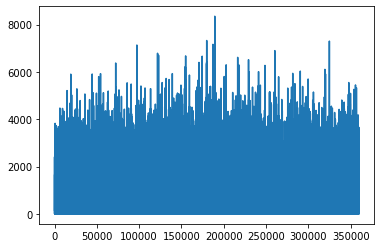

In [151]:
plt.plot(diff)

In [152]:
df.head()

,height,time,fee,reward,time_diff
1,500001,2017-12-18 18:38:05,363420702,1250000000,160.0
2,500002,2017-12-18 18:41:04,341013739,1250000000,179.0
3,500003,2017-12-18 18:46:28,363546598,1250000000,324.0
4,500004,2017-12-18 18:47:21,289758471,1250000000,53.0
5,500005,2017-12-18 19:05:31,443780733,1250000000,1090.0


In [153]:
df['time_diff'].rolling(window=10, min_periods=1).mean(), len(df.height)

(1         160.0
 2         169.5
 3         221.0
 4         179.0
 5         361.2
           ...  
 359605    559.4
 359606    581.0
 359607    631.8
 359608    579.5
 359609    574.3
 Name: time_diff, Length: 359609, dtype: float64,
 359609)

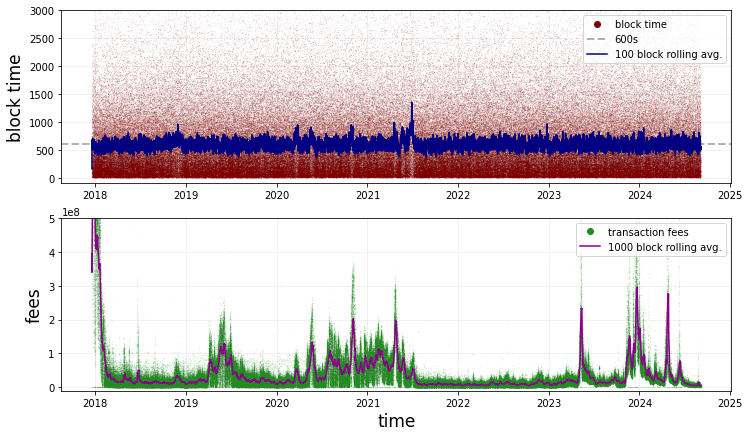

In [157]:
f, axarr = plt.subplots(nrows=2, figsize=(12,7))

axarr[0].plot(df.time, df.time_diff, color='maroon', linestyle='none', marker='o', fillstyle='full',
              label=r'block time', alpha=0.2, markersize=0.2)

rolling = df.time_diff.rolling(window=100, min_periods=1).mean()
axarr[0].axhline(600, color='k', linewidth=2, alpha=0.3, label='600s', linestyle='--')
axarr[0].plot(df.time, rolling, color='navy', linestyle='-', label=r'100 block rolling avg.')

axarr[1].plot(df.time, df.fee, color='forestgreen', linestyle='none', marker='o', fillstyle='full',
              label=r'transaction fees', alpha=0.2, markersize=0.2)
rolling = df.fee.rolling(window=1000, min_periods=1).mean()
axarr[1].plot(df.time, rolling, color='darkmagenta', linestyle='-', label=r'1000 block rolling avg.')


axarr[0].set_ylim(-100, 3000)
axarr[1].set_ylim(-10000000, int(5e8))
axarr[1].set_xlabel('time', size=17)
axarr[1].set_ylabel('fees (sats)', size=17)
axarr[0].set_ylabel('block time', size=17)

for ax in axarr:
    lgnd = ax.legend(loc=1, markerscale=50)
    lgnd.legendHandles[0]._legmarker.set_markersize(6)
    lgnd.legendHandles[0]._legmarker.set_alpha(1)
    ax.grid(alpha=0.2)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

In [160]:
len(df.time_diff), len(df.fee)

(359609, 359609)

In [235]:
rolling_fee     = df.fee.rolling(window=50, min_periods=50).mean()
rolling_fee_250 = df.fee.rolling(window=250, min_periods=250).mean()
rolling_fee_1k  = df.fee.rolling(window=100000, min_periods=100000).mean()
len(rolling_fee_1k), len(df.time_diff)

(359609, 359609)

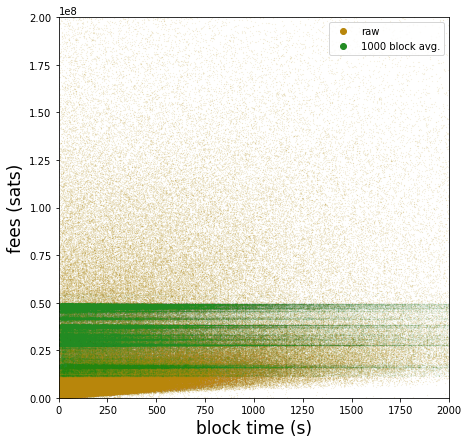

In [236]:
f, ax = plt.subplots(figsize=(7,7))

ax.plot(df.time_diff, df.fee, marker='o', markersize=0.1, color='darkgoldenrod', linestyle='none', 
        label='raw', alpha=0.4)

# ax.plot(df.time_diff, rolling_fee, marker='o', markersize=0.1, color='darkturquoise', linestyle='none', 
#         label='100 block avg.', alpha=0.4)

# ax.plot(df.time_diff, rolling_fee_250, marker='o', markersize=0.1, color='firebrick', linestyle='none', 
#         label='1000 block avg.', alpha=0.2)

ax.plot(df.time_diff, rolling_fee_1k, marker='o', markersize=0.1, color='forestgreen', linestyle='none', 
        label='1000 block avg.', alpha=0.2)


ax.set_ylim(0, int(2e8))
ax.set_xlim(0, 2000)

# axarr[0].set_ylim(-100, 3000)
# axarr[1].set_ylim(-10000000, int(5e8))
ax.set_xlabel('block time (s)', size=17)
ax.set_ylabel('fees (sats)', size=17)
# axarr[0].set_ylabel('block time', size=17)

lgnd = ax.legend(loc=1, markerscale=50)
for lh in lgnd.legendHandles:
    lh._legmarker.set_markersize(6)
    lh._legmarker.set_alpha(1)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

In [187]:
# blocks within 400-800 seconds
df_normal = df[df['time_diff'] > 400]
df_normal = df_normal[df_normal['time_diff'] < 800]
df_normal.head()

,height,time,fee,reward,time_diff
7,500007,2017-12-18 19:34:15,434274129,1250000000,729.0
11,500011,2017-12-18 20:03:29,419161152,1250000000,754.0
13,500013,2017-12-18 20:15:20,399960628,1250000000,544.0
15,500015,2017-12-18 20:25:40,419677574,1250000000,574.0
17,500017,2017-12-18 20:41:03,407471343,1250000000,529.0


In [196]:
sorted_time = df_normal.sort_values('time_diff')
sorted_time.tail()

,height,time,fee,reward,time_diff
337640,837640,2024-04-04 05:18:39,13548493,625000000,799.0
91187,591187,2019-08-22 04:14:11,42475468,1250000000,799.0
91412,591412,2019-08-23 18:05:35,40830701,1250000000,799.0
153390,653390,2020-10-19 07:04:36,34422847,625000000,799.0
237831,737831,2022-05-25 11:16:14,33655203,625000000,799.0


In [203]:
rolling_fee = sorted_time.fee.rolling(window=50, min_periods=50).mean()
rolling_fee_250 = sorted_time.fee.rolling(window=250, min_periods=250).mean()
len(rolling_fee), len(sorted_time.time_diff)

(90252, 90252)

In [206]:
from scipy.stats import linregress

res = linregress(sorted_fees.time_diff, sorted_fees.fee)
res

LinregressResult(slope=28559.00826403216, intercept=26719328.91010663, rvalue=0.04169202208883056, pvalue=5.091845359307679e-36, stderr=2278.1839008107927)

In [209]:
res.rvalue**2

0.0017382247058555355

In [218]:
lr = np.arange(400,800,1) * res.slope + res.intercept

In [217]:
lr.shape

(400,)

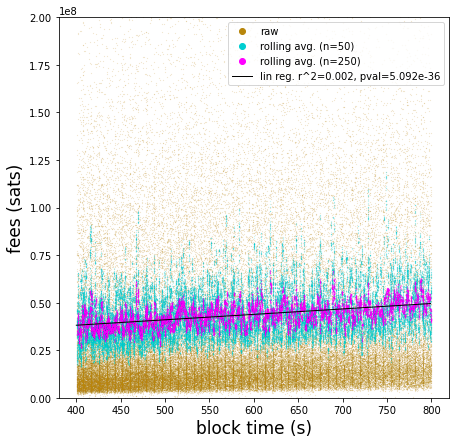

In [224]:
f, ax = plt.subplots(figsize=(7,7))

ax.plot(sorted_fees.time_diff, sorted_fees.fee, marker='o', markersize=0.1, color='darkgoldenrod', 
        linestyle='none', label='raw', alpha=0.7)

ax.plot(sorted_time.time_diff, rolling_fee, marker='o', markersize=0.1, color='darkturquoise', linestyle='none', 
        label='rolling avg. (n=50)', alpha=0.7)
ax.plot(sorted_time.time_diff, rolling_fee_250, marker='o', markersize=0.1, color='magenta', linestyle='none', 
        label='rolling avg. (n=250)', alpha=0.4)

ax.plot(np.arange(400,800,1), lr, linewidth=1, color='black', linestyle='-', 
        label='lin reg. r^2={:0.3f}, pval={:0.3e}'.format(res.rvalue**2, res.pvalue), alpha=1)


# ax.plot(rolling_time_1k, rolling_fees_1k, marker='o', markersize=0.1, color='firebrick', linestyle='none', 
#         label='1000 block avg.', alpha=0.2)


ax.set_ylim(0, int(2e8))
ax.set_xlim(380, 820)

# axarr[0].set_ylim(-100, 3000)
# axarr[1].set_ylim(-10000000, int(5e8))
ax.set_xlabel('block time (s)', size=17)
ax.set_ylabel('fees (sats)', size=17)
# axarr[0].set_ylabel('block time', size=17)

lgnd = ax.legend(loc=1, markerscale=50)
for lh in lgnd.legendHandles:
    lh._legmarker.set_markersize(6)
    lh._legmarker.set_alpha(1)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()